# Tutorial 1 - FeRh

In [1]:
# Ignore the following commands, they are required to use EntroPy without installing it as a package
import sys
sys.path.append('.')

___

## Getting started

In order to use the necessary functions/routines in the notebooks/scripts or directly in the python console, we start by importing the EntroPy module:

In [2]:
import EntroPy

And a couple more of utlitiy modules:

In [3]:
import matplotlib.pyplot as plt # Usefull for plotting
import numpy as np  # VERY usefull for handling arrays

Now, we have everthing necessary to start the post-processing :)

## A) Electronic contribution

### Basic usage

Let's start by loading the data. In the FeRh folder you can find 2 standard DOS calculated on RSPt with the green.inp file (and in eV).

Feel free to read the data as you prefer, but if you have CSV like data file, the function genfromtxt from numpy is easy and efficent to use:

In [4]:
dos_FM = np.genfromtxt("FeRh/fm_dos")
dos_AFM = np.genfromtxt("FeRh/afm_dos")

Read this way, the data is organized the following way (have a look at the data file):

* _dos_FM [:,0]_ corresponds to the column of Energy
* _dos_FM [:,1]_ corresponds to the column of Total Trace
* _dos_FM [:,2]_ corresponds to the column of Spin Up (spin axis)
* ...

Let's have a look at the read DOS:

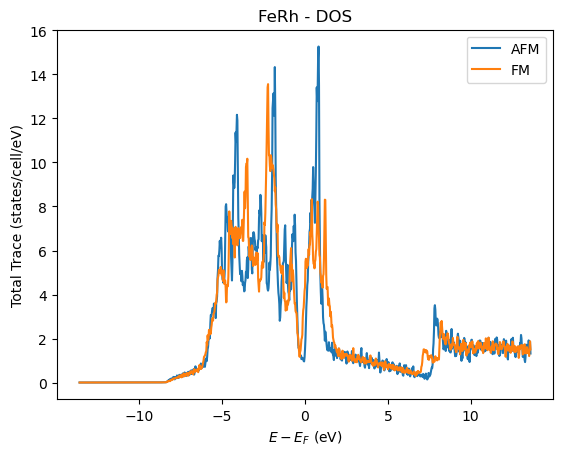

In [5]:
plt.plot(dos_AFM[:,0],dos_AFM[:,1],label='AFM')
plt.plot(dos_FM[:,0],dos_FM[:,1],label='FM')
plt.legend()
plt.title("FeRh - DOS")
plt.xlabel("$E-E_F$ (eV)")
plt.ylabel("Total Trace (states/cell/eV)")
plt.show()

Now, our fist goal, let's calculate the electronic contribution for the Entropy!

$S_{ele} = - k_B \int DOS(\epsilon)\Big[ \Big(1-f(\epsilon,T) \Big)ln\Big(1-f(\epsilon,T)\Big) + f(\epsilon,T)ln\Big(f(\epsilon,T)\Big) \Big] d\epsilon$

where $f(E,T)$ is the Fermi-Dirac distribution:

$f(E,T) = \frac{1}{\exp(\frac{E-\mu}{k_B T})+1}$, we take here $\mu=E_{Fermi}$ which is exact at 0K. The consequence of this shortcut is that we will be losing some electrons. The effect is relevant when $T\rightarrow 0$ . See plots in the end of notebook.


To do this computation, we can call the S_ele function from the EntroPy module. Basic usage: `EntroPy.S_ele(energy,dos,temperature)`

Here, the temperature can be a single value:

In [6]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],5) # Electronic entropy at 5K

array([0.01804738])

Or a list of temperatures, in that case the entropy is calculated for each temperature and returned in the respective order

In [7]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],[10,20,30,40,5])

array([0.03597946, 0.07208919, 0.10832794, 0.14470152, 0.01804738])

Above we have the calculated electronic entropy at 10, 20,30,40 and 5K respectively

___

### [Exercise 1] Calculate the eletronic entropy for both phases in the temperature range 0-500K

* a) Create a list named T with the temperatures to be calculated;
* b) Calulate the eletronic entropy for the AFM phase for the temperatures T and associate it to S_ele_AFM;
* c) Repeat previous step but for the FM phase and associate it to S_ele_FM;

Tip: `np.arange(initial,final,step)` generates an array/list starting in 'initial' and ending the closest possible to 'final'-1 according to the 'step' provided

If you get lost or are in a hurry have a look at the solution proposed in the cheat sheet in the end of the notebook :)

Let's have a look at it :)

In [8]:
# Please uncomment the following lines and execute them:
# plt.plot(T,S_ele_AFM,label='AFM')
# plt.plot(T,S_ele_FM,label='FM')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('S$_{ele} (J/mol/K)$')
# plt.show()

___

### More important info

**I ) UNITS**

The code assumes that the DOS and energies provided are in [eV]. If it is not case you can specify the units using the optional argument units:
`S_ele(energies,dos,temperature,units='unit')`

Currently accepted units:
* eV  (default) :   S_ele(energies,dos,temperature,units='eV')
* Ry :              S_ele(energies,dos,temperature,units='Ry')
* J  :              S_ele(energies,dos,temperature,units='J')
* kb :              S_ele(energies,dos,temperature,units='kb')


**However the units from the input, the calculated entropy will be in [J/K/mol]**

Note if the DOS provided is in states per cell, as is the standard in most DFT codes, then the entropy will be also per cell [J/mol/K/cell] . Then it might be usefull, to convert it [J/mol/K/atom] by dividing for the number of atoms in the unit cell. 

**II ) DOS shift ($E-E_{fermi}$)**

The code assumes that the DOS is shifted according to the Fermi energy ($E-E_{Fermi}$). **If it is not** the case please specify the Fermi Energy: `S_ele(energies,dos,temperature,Ef=$E_{Fermi}$)`

By default Ef=0

### Numerical details

If the DOS is very sharp, the numerical integration can become more tricky. To avoid loss of accuracy, in the code, the DOS is linearly interpolated and additional points are calculated in between the original ones.

The number of points can be controlled with the  Ndiv optional argument, the default value is 25:
`S_ele(energies,dos,temperature,Ndiv=25)`

**It is a good idea to test if the entropy is converged to the choice of Ndiv**

In [9]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],5,Ndiv=1) # Entropy at 5K, no interpolation

array([0.23896784])

In [10]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],5,Ndiv=2) # Entropy at 5K, Ndiv=2

array([4.36319999e-07])

In [11]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],5) # Entropy at 5K, default Ndiv=25

array([0.01804738])

In [12]:
EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],5,Ndiv=50) # Entropy at 5K, default Ndiv=50

array([0.01797466])

Increasing Ndiv increases the numerical effort, and for big values the calculation will take some time. If that happens is recommended to use a smoother DOS. One can calculate the DOS again with a bigger smearing. Or, one can use an gaussian smearing function from the code:
`EntroPy.core.apply_gaussian_smearing(energy,dos,sigma)`

In [13]:
# Smeared dos with  sigma of 0.07 eV (same units as the energy provided):
smeared_dos = EntroPy.core.apply_gaussian_smearing(dos_AFM[:,0],dos_AFM[:,1],0.07)

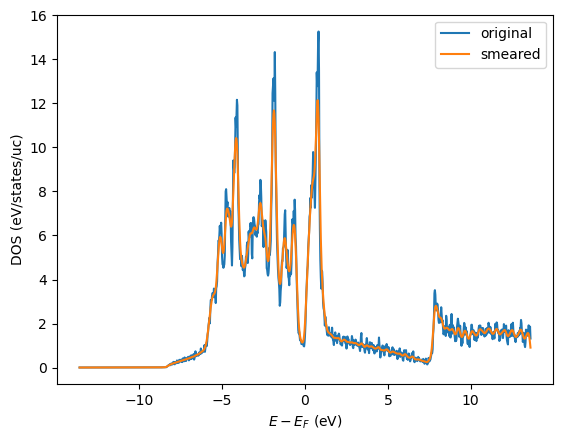

In [14]:
plt.plot(dos_AFM[:,0],dos_AFM[:,1],label='original')
plt.plot(dos_AFM[:,0],smeared_dos,label='smeared')
plt.legend()
plt.ylabel('DOS (eV/states/uc)')
plt.xlabel('$E-E_F$ (eV)')
plt.show()

### Electronic free energy

To calculate the free energy we use the relation:

$F = U - TS$

where $S$ for the eletronic component was already defined above. And $U$ for the electronic subsystem is given by:

$F_{ele} = \epsilon DOS(\epsilon) f(\epsilon,T) d\epsilon -  \int \epsilon DOS(\epsilon) f(\epsilon,T=0) d\epsilon$

i.e.

$F_{ele} = \int  \epsilon DOS(\epsilon) f(\epsilon,T) d\epsilon - E0 $

* Usage of F_ele is exactly identical to S_ele:

`EntroPy.F_ele(energy,dos,temperature)`

Including the optional arguments: units,Ef,Ndiv

* The calculated free energy is given in [J/mol]

___

### [Exercise 2] - Calculate the eletronic free energy for both phases in the temperature range 0-500K

* a) Create a list named T with the temperatures to be calculated;
* b) Calulate the eletronic free energy for the AFM phase for the temperatures T and associate it to F_ele_AFM;
* c) Repeat previous step but for the FM phase and associate it to F_ele_FM;

 If you get lost or are in a hurry have a look at the solution proposed in the cheat sheet in the end of the notebook :)

Let's have a look at it :)

In [15]:
# # Please uncomment the following lines and execute them:
# plt.plot(T,F_ele_AFM,label='AFM')
# plt.plot(T,F_ele_FM,label='FM')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('F$_{ele} (J/mol)$')
# plt.show()

**Notice that $F_{ele}$=0 at T=0K !** There was a deliberate choice to consider the free energy from the electronic **excitations**.

___

## B) Lattice contribution

Now that we are warmed up we can move to the vibrational contribution of the entropy.

To do so we calculate the entropy from the phonons (bosons):  

$S_{lat} = 3 k_B \int_0^\infty VDOS(\epsilon) \Big[ \Big(1 + n(\epsilon,T)\Big) ln\Big(1 + n(\epsilon,T)\Big) - n(\epsilon,T) ln\Big(n(\epsilon,T)\Big) \Big] d\epsilon$

where, VDOS is the vibrational density of states and $n(\epsilon,T)$ is the Bose-Einstein distribution:

$g(E,T) = \frac{1}{\exp(\frac{E}{k_B T})-1}$


As before, we start by reading the VDOS. In the FeRh folder you can find 2 standard VDOS calculated with phonopy (Frequency [THz] vs vDOS [states/THz/cell] )

In [31]:
vdos_FM  = np.genfromtxt('FeRh/fm_vdos.dat')
vdos_AFM  = np.genfromtxt('FeRh/afm_vdos.dat')

Let's have a look:

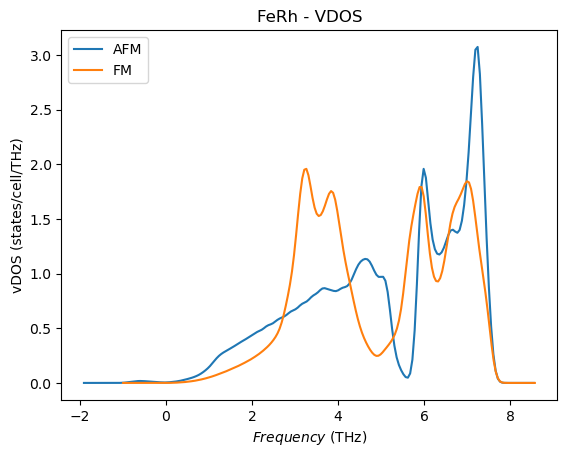

In [17]:
plt.plot(vdos_AFM[:,0],vdos_AFM[:,1],label='AFM')
plt.plot(vdos_FM[:,0],vdos_FM[:,1],label='FM')
plt.legend()
plt.title("FeRh - VDOS")
plt.xlabel("$Frequency$ (THz)")
plt.ylabel("vDOS (states/cell/THz)")
plt.show()

To calculate the entropy we can call the S_phonons function from the EntroPy module. Basic usage: 

`EntroPy.S_phonons(frequency/energy,vdos,temperature)`


**UNITS**

The code assumes that the vDOS and frequency/energy provided are in [THz]. If it is not case you can specify the units using the optional argument units:
`S_phonons(frequency/energy,vdos,temperature,units='unit')`

Currently accepted units:
* THz (default)     S_phonons(frequencies,vdos,temperature,units='THz')
* eV :              S_phonons(energies,vdos,temperature,units='eV')
* Ry :              S_phonons(energies,vdos,temperature,units='Ry')
* J  :              S_phonons(energies,vdos,temperature,units='J')
* kb :              S_phonons energies,vdos,temperature,units='kb')


As before the calculated entropy will be in [J/K/mol]

Phonopy provides VDOS states per primitive cell, then the entropy will be also per primitive cell [J/mol/K/cell] . Then it might be usefull, to convert it [J/mol/K/atom] by dividing for the number of atoms in the primitive cell. 

**Important** 

The vdos calculated by phonopy often extends to negative frequencies even if only VDOS is (hopefully) zero in that region. Because of this, using directly the vdos from phonopy will crash $S_{phonons}$.

For now we have to filter out this entries from vdos. One can delete the lines manually in the data file. Here follows a quick way of filtering them out in python with 'np.where'

In [18]:
# First we find here Frequency>=0:
#
# np.where(vdos_AFM[:,0]>= 0)[0]  returns the indexes where Frequency>=0
#
# Then we create a new array from those indexes
new_vdos_AFM = vdos_AFM[np.where(vdos_AFM[:,0]>= 0)[0]]
new_vdos_FM = vdos_FM[np.where(vdos_FM[:,0]>= 0)[0]]

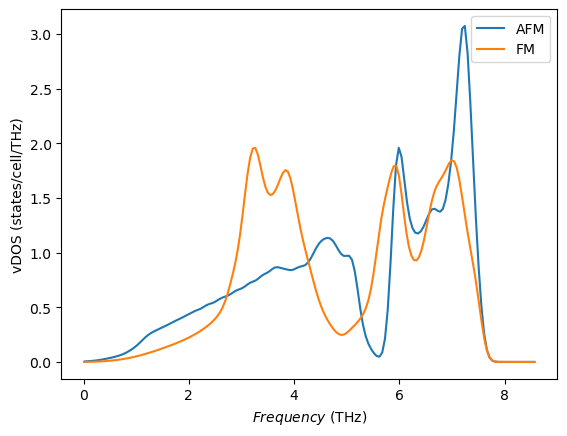

In [19]:
# Here it goes how it looks
plt.plot(new_vdos_AFM[:,0],new_vdos_AFM[:,1],label='AFM')
plt.plot(new_vdos_FM[:,0],new_vdos_FM[:,1],label='FM')
plt.legend()
plt.xlabel("$Frequency$ (THz)")
plt.ylabel("vDOS (states/cell/THz)")
plt.show()

Guess what is coming ?! 
___

### [Exercise 3] - Calculate the lattice entropy for both phases in the temperature range 1-500K

* a) Create a list named T with the temperatures to be calculated;
* b) Calulate the lattie entropy for the AFM phase for the temperatures T and associate it to S_lat_AFM;
* c) Repeat previous step but for the FM phase and associate it to S_lat_FM;

As always, proposed solution in the cheat sheet :)

In [20]:
# Please uncomment the following lines and execute them:
# plt.plot(T,S_lat_AFM,label='AFM')
# plt.plot(T,S_lat_FM,label='FM')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('S$_{lat} (J/mol/K)$')
# plt.show()

___

## C) Magnetic Entropy

The first-order transition of AFM-FM of FeRh, is peculiar since is order-order transition. Since it happens relatively far(in the tmperature scale) from the order-disorder transition of the respective phases, the description of the magnetic excitation via magnons is still a reasonable choice.

The magnons are bosons, just as the phonons so the entropy calculation is very similar:  

$S_{magnons} = k_B \int_0^\infty mDOS(\epsilon) \Big[ \Big(1 + n(\epsilon,T)\Big) ln\Big(1 + n(\epsilon,T)\Big) - n(\epsilon,T) ln\Big(n(\epsilon,T)\Big) \Big] d\epsilon$

(here we don't have the factor of 3)

Now $mDOS$ is the magnons density of states

As before, we start by reading the data:

In [21]:
mdos_FM = np.genfromtxt("FeRh/fm_magdos")
mdos_AFM = np.genfromtxt("FeRh/afm_magdos")

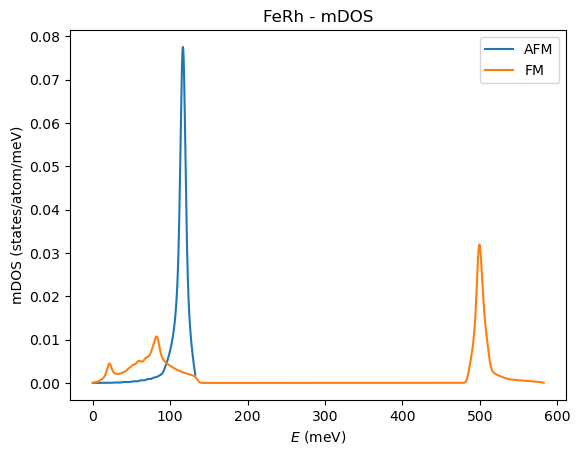

In [22]:
plt.plot(mdos_AFM[:,0],mdos_AFM[:,1],label='AFM')
plt.plot(mdos_FM[:,0],mdos_FM[:,1],label='FM')
plt.legend()
plt.title("FeRh - mDOS")
plt.xlabel("$E$ (meV)")
plt.ylabel("mDOS (states/atom/meV)")
plt.show()

We can use the function **S_bosons** to calculate $S_{mag}$ from the $mDos$. Basic usage:

`EntroPy.S_bosons(energy,dos,temperature)`

**UNITS**

The functions S_bosons expects the energy scale of mDOS to be in eV. However it accepts the same "units" argument as S_phonons 
As before the calculated entropy will be in [J/K/mol]

If you calculate the mDOS with UppASD it will come in meV, so don't forget to convert it! Here follows a quick way of doing it:

In [23]:
mdos_FM[:,0] /= 1000 # Dividing energy by 1000
mdos_FM[:,1] *= 1000 # Multiplying the DOS by 1000

mdos_AFM[:,0] /= 1000 
mdos_AFM[:,1] *= 1000

As before, keep in mind that the mDos is likely to come in states/energy/cell or states/energy/atom, in the UppASD is the latter, so the calculated $S_{mag}$ will be in [J/K/mol/atom]

Now we are ready to calculate the magnetic entropy, and you guessed right, is an exercise :)
___

### [Exercise 4] - Calculate the magnetic entropy for both phases in the temperature range 1-500K

* a) Create a list named T with the temperatures to be calculated;
* b) Calulate the magnetic entropy for the AFM phase for the temperatures T and associate it to S_mag_AFM;
* c) Repeat previous step but for the FM phase and associate it to S_mag_FM;

Proposed solution in the cheat sheet :)

In [24]:
# Please uncomment the following lines and execute them:
# plt.plot(T,S_mag_AFM,label='AFM')
# plt.plot(T,S_mag_FM,label='FM')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('S$_{lat} (J/mol/K)$')
# plt.show()

___

# D) Total entropy

The time was come to compute the total entropy:

$S_{total} = S_{ele} + S_{mag} + S_{lat}$


And compute the difference of entropies: $\Delta S = S_{AFM} - S_{FM}$

___

### [Exercise 4] - Reproduce this curves in the range 1-500K

<img src ="./FeRh/entropy.png" alt="Alt text" />

* a) Create a list named T with the temperatures to be calculated;
* b) Recalculate all the entropy contributions S_mag_AFM, S_lat_AFM, S_ele_AFM, S_mag_FM, S_lat_FM, S_ele_FM in this temperature range;
* c) Calulate the total entropy for the AFM phase and associate it S_tot_AFM;
* d) Repeat previous step but for the FM phase and associate it to S_tot_FM;

** Important ! ** Keep in mind that the provided DOS and vDOS are per cell while mDOS is per atom. Keep that in mind for on step b) 

Proposed solution in the cheat sheet :)

In [25]:
# Please uncomment the following lines and execute them:
# plt.plot(T,S_tot_AFM,label='AFM')
# plt.plot(T,S_tot_FM,label='FM')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('S$_{tot} (J/mol/K)$')
# plt.show()

In [26]:
# Please uncomment the following lines and execute them:
# plt.plot(T,S_tot_FM-S_tot_AFM,label='$S_{tot}$')
# plt.plot(T,S_lat_FM-S_lat_AFM,label='$S_{lat}$')
# plt.plot(T,S_mag_FM-S_mag_AFM,label='$S_{mag}$')
# plt.plot(T,S_ele_FM-S_ele_AFM,label='$S_{ele}$')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('$\Delta S_{tot} (J/mol/K)$')
# plt.show()

___

## Cheat list

Exercise 1

```
T = np.arange(0,501,1)
S_ele_AFM = EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],T)
S_ele_FM = EntroPy.S_ele(dos_FM[:,0],dos_FM[:,1],T)
```

Exercise 2

```
T = np.arange(0,501,1)
F_ele_AFM = EntroPy.F_ele(dos_AFM[:,0],dos_AFM[:,1],T)
F_ele_FM = EntroPy.F_ele(dos_FM[:,0],dos_FM[:,1],T)
```

Exercise 3
```
T=np.arange(1,501,1)
S_lat_FM = EntroPy.S_phonons(new_vdos_FM[:,0],new_vdos_FM[:,1],T)
S_lat_AFM = EntroPy.S_phonons(new_vdos_AFM[:,0],new_vdos_AFM[:,1],T)
```

Exercise 4
```
T=np.arange(1,501)

S_ele_AFM = EntroPy.S_ele(dos_AFM[:,0],dos_AFM[:,1],T)/4
S_ele_FM = EntroPy.S_ele(dos_FM[:,0],dos_FM[:,1],T)/4
S_lat_FM = EntroPy.S_phonons(new_vdos_FM[:,0],new_vdos_FM[:,1],T)/4
S_lat_AFM = EntroPy.S_phonons(new_vdos_AFM[:,0],new_vdos_AFM[:,1],T)/4
S_mag_FM = EntroPy.S_bosons(mdos_FM[:,0],mdos_FM[:,1],T)
S_mag_AFM = EntroPy.S_bosons(mdos_AFM[:,0],mdos_AFM[:,1],T)

S_tot_AFM = S_ele_AFM + S_lat_AFM + S_mag_AFM
S_tot_FM = S_ele_FM + S_lat_FM + S_mag_FM
```

## Effect of the simplification $\mu=E_{fermi}$

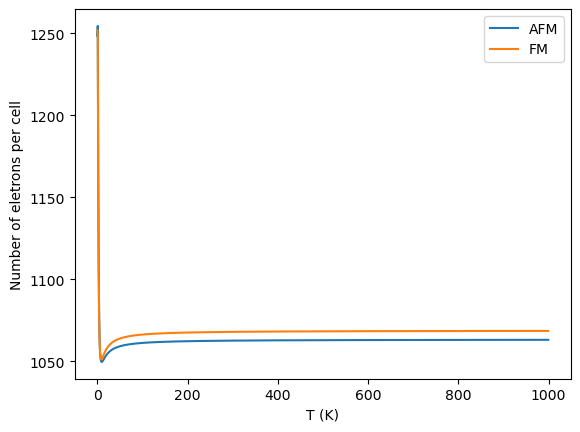

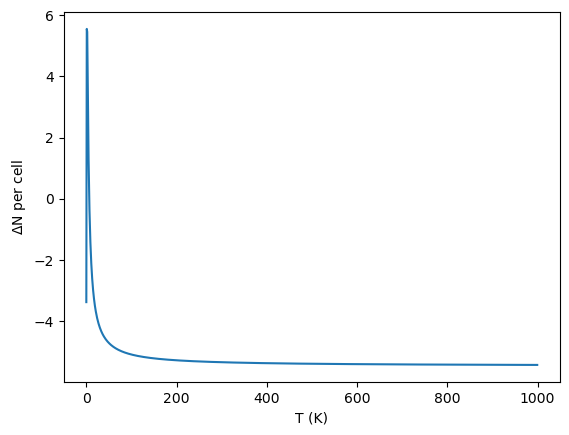

In [27]:
T=np.arange(0,1000)
N_el_afm = np.trapz(dos_AFM[:,1]*EntroPy.core.dist_FD(dos_AFM[:,0],T),axis=1)
N_el_fm = np.trapz(dos_FM[:,1]*EntroPy.core.dist_FD(dos_FM[:,0],T),axis=1)

plt.plot(T,N_el_afm,label='AFM')
plt.plot(T,N_el_fm,label='FM')
plt.legend()
plt.ylabel('Number of eletrons per cell')
plt.xlabel('T (K)')
plt.show()
plt.plot(T,N_el_afm-N_el_fm)
plt.ylabel('$\Delta$N per cell')
plt.xlabel('T (K)')
plt.show()